#### Import Library

In [1]:
# Data Reading 
import os
from glob import glob
from PIL import Image,ImageOps
from tqdm import tqdm

# Data Processing 
import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

# Data Modeling & Model Evaluation
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

#### Preparing Image Data

In [2]:
normPath = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
covPath = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"

print('Jumlah X-Ray Normal: ', len(os.listdir(normPath)))
print('Jumlah X-Ray COVID: ', len(os.listdir(covPath)))

Jumlah X-Ray Normal:  10192
Jumlah X-Ray COVID:  3616


Shape:  (299, 299, 3)


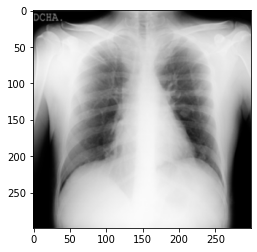

In [3]:
#Random image info

img_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1000.png'

img = tf.keras.utils.load_img(img_path)
img = np.asanyarray(img)
print('Shape: ', img.shape)

plt.imshow(img)
plt.show()

In [4]:
tot_images=[]

In [5]:
# Preparing COVID X-Ray Images

for image in tqdm(os.listdir(covPath)):
    img=Image.open(os.path.join(covPath,image))
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    tot_images.append(img)

100%|██████████| 3616/3616 [00:23<00:00, 150.77it/s]


In [6]:
# Preparing Normal X-Ray Images

for image in tqdm(os.listdir(normPath)):
    img=Image.open(os.path.join(normPath,image))
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    tot_images.append(img)

100%|██████████| 10192/10192 [01:09<00:00, 145.87it/s]


In [7]:
# Set label for images
# 0 = Negative, 1 = Positive

img_labels=[1]*len(os.listdir(covPath))+[0]*(len(os.listdir(normPath)))
print(np.unique(img_labels,return_counts=True))

(array([0, 1]), array([10192,  3616]))


In [8]:
# Convert list to arrays

tot_images=np.array(tot_images)
img_labels=np.array(img_labels)
print(tot_images.shape,img_labels.shape)

(13808, 64, 64, 1) (13808,)


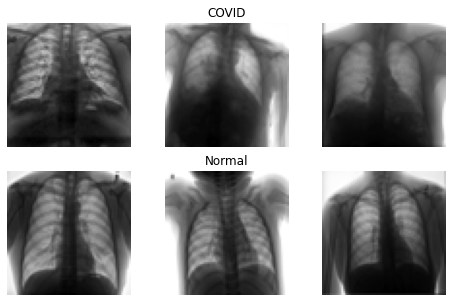

In [9]:
# Image Samples

fig, im = plt.subplots(2, 3, figsize=(8,5))

im[0,1].set_title('COVID')
im[0,0].imshow(tot_images[100], cmap=plt.cm.binary)
im[0,1].imshow(tot_images[101], cmap=plt.cm.binary)
im[0,2].imshow(tot_images[102], cmap=plt.cm.binary)

im[1,1].set_title('Normal')
im[1,0].imshow(tot_images[4000], cmap=plt.cm.binary)
im[1,1].imshow(tot_images[4001], cmap=plt.cm.binary)
im[1,2].imshow(tot_images[4002], cmap=plt.cm.binary)

[imi.set_axis_off() for imi in im.ravel()]
plt.show()

In [10]:
# Normalising dataset

tot_images=tot_images/255

In [11]:
# Shuffling dataset

tot_images,img_labels=shuffle(tot_images,img_labels)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(tot_images,img_labels,test_size=0.2, stratify=img_labels)

In [13]:
print(x_test.shape,y_test.shape)
print(x_train.shape,y_train.shape)
print(np.unique(y_test,return_counts=True))
print(np.unique(y_train,return_counts=True))

(2762, 64, 64, 1) (2762,)
(11046, 64, 64, 1) (11046,)
(array([0, 1]), array([2039,  723]))
(array([0, 1]), array([8153, 2893]))


In [14]:
# Balancing The Dataset

from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.7)
x_train,y_train = oversample.fit_resample(x_train.reshape(x_train.shape[0],-1), y_train)
print(len(x_train),len(y_train))

13860 13860


In [15]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=1)
x_train,y_train=under.fit_resample(x_train,y_train)
print(np.unique(y_train,return_counts=True))
x_train=x_train.reshape(x_train.shape[0],64,64,1)
print(x_train.shape,y_train.shape)

(array([0, 1]), array([5707, 5707]))
(11414, 64, 64, 1) (11414,)


#### Model CNN

In [16]:
# CNN model architecture 

cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (64, 64, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 64, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 1, activation = 'sigmoid'))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.BinaryCrossentropy(), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

In [18]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
41/41 [==============================] - 19s 439ms/step - loss: 0.6032 - accuracy: 0.6579 - val_loss: 0.5613 - val_accuracy: 0.7277
Epoch 2/50
41/41 [==============================] - 18s 439ms/step - loss: 0.5111 - accuracy: 0.7442 - val_loss: 0.5081 - val_accuracy: 0.7785
Epoch 3/50
41/41 [==============================] - 18s 429ms/step - loss: 0.4388 - accuracy: 0.7863 - val_loss: 0.4318 - val_accuracy: 0.8240
Epoch 4/50
41/41 [==============================] - 18s 446ms/step - loss: 0.3747 - accuracy: 0.8303 - val_loss: 0.3625 - val_accuracy: 0.8599
Epoch 5/50
41/41 [==============================] - 17s 425ms/step - loss: 0.3426 - accuracy: 0.8486 - val_loss: 0.3150 - val_accuracy: 0.8722
Epoch 6/50
41/41 [==============================] - 18s 444ms/step - loss: 0.2939 - accuracy: 0.8755 - val_loss: 0.2961 - val_accuracy: 0.8879
Epoch 7/50
41/41 [==============================] - 18s 429ms/step - loss: 0.2710 - accuracy: 0.8863 - val_loss: 0.2727 - val_accuracy: 0.8993

#### Model Evaluation

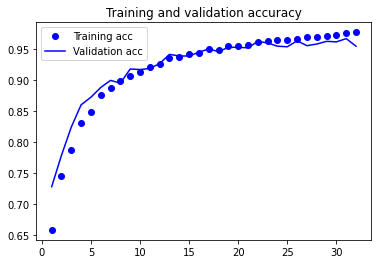

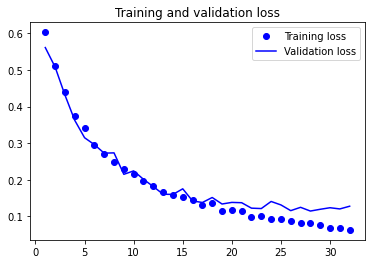

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
cnn_model.save('covdet_cnn_2.h5')

In [21]:
yp_train = cnn_model.predict(x_train)
yp_train = yp_train > 0.5

yp_test = cnn_model.predict(x_test)
yp_test = yp_test > 0.5

In [22]:
def evaluation_parametrics(name, y_train, yp_train, y_test, yp_test):
    
    print("\n------------------------{}------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t2 = ConfusionMatrixDisplay(cm_test)    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")

    t1.plot()
    t2.plot()


------------------------Convolution Neural Network------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5128
           1       0.99      0.99      0.99      5144

    accuracy                           0.99     10272
   macro avg       0.99      0.99      0.99     10272
weighted avg       0.99      0.99      0.99     10272

--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2039
           1       0.88      0.94      0.91       723

    accuracy                           0.95      2762
   macro avg       0.93      0.95      0.94      2762
weighted avg       0.95      0.95      0.95      2762

--------------------------------------------------------------------------


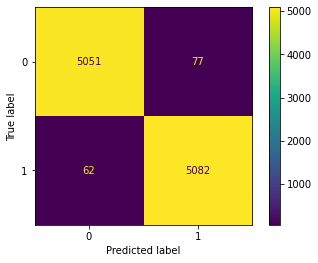

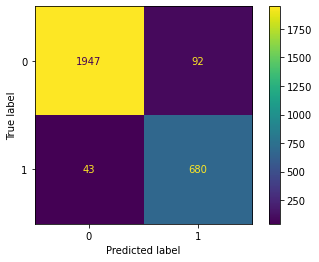

In [23]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_test, yp_test)

In [24]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)

print('test_acc:', test_acc)
print('test_loss:', test_loss)

87/87 [==============================] - 1s 15ms/step - loss: 0.1309 - accuracy: 0.9511
test_acc: 0.9511224031448364
test_loss: 0.13085126876831055
